In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from tradealgorithm.tradealgorithm import TradeAlgorithm
from tradealgorithm.tradealgorithmfactory import TradeAlgorithmFactory
from pricer.pricer_factory import PricerFactory
from pricer.pricer import Pricer
from ranker.ranker_factory import RankerFactory
from ranker.ranker import Ranker
from classifier.classifier_factory import ClassifierFactory
from classifier.classifier import Classifier
from datetime import datetime

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
start = datetime(2001,1,1)
end  = datetime(2023,1,1)
current_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
pricer_classes = [] 
pricer_classes.append(Pricer.DAILY_STOCK_MEANREVERSION)
pricer_classes.append(Pricer.DAILY_STOCK_DEVROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_BREAKOUT)
pricer_classes.append(Pricer.DAILY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_ROLLING)
pricer_classes.append(Pricer.WEEKLY_STOCK_WINDOW)
pricer_classes.append(Pricer.WEEKLY_STOCK_ROLLING)

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields10"),10)
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()
current = False
ranker_class = Ranker.NONE
classifier_class = Classifier.NONE

In [7]:
analysis = []
trade_algos = []
for pricer_class in tqdm(pricer_classes):
    trade_algo = TradeAlgorithmFactory.build(TradeAlgorithm.RRR_BETA)
    trade_algo.initialize(pricer_class,ranker_class,classifier_class,start,end,current_date)
    trade_algo.initialize_bench_and_yields()
    trade_algo.initialize_classes()
    trade_algos.append(trade_algo)
    trade_algo.db.connect()
    parameters = trade_algo.pull_iterations().to_dict("records")
    for parameter in tqdm(parameters):
        try:
            trade = trade_algo.db.query("trades",{"iteration":parameter["iteration"]})
            if trade.index.size > 0:
                positions = int(trade_algo.positions) if trade_algo.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  trade_algo.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                anas = trade_algo.analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["trade_algo"] = trade_algo.name
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    analysis.append(cumulative[list(parameter.keys()) + ["trade_algo","pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    trade_algo.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

 49%|███████████████████████████████████████████████████████████████████████▎                                                                         | 177/360 [00:05<00:05, 31.12it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 260/360 [01:05<01:38,  1.02it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 303/360 [02:18<01:36,  1.70s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 346/360 [03:32<00:23,  1.69s/it]


  8%|██████████▉                                                                                                                                       | 27/360 [00:46<09:29,  1.71s/it]


 19%|████████████████████████████▍                                                                                                                     | 70/360 [01:55<08:12,  1.70s/it]


 31%|█████████████████████████████████████████████▌                                                                                                   | 113/360 [03:09<07:04,  1.72s/it]


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 156/360 [04:19<05:48,  1.71s/it]


  0%|                                                                                                                                                           | 0/360 [00:00<?, ?it/s]


 12%|█████████████████▍                                                                                                                                | 43/360 [01:14<09:11,  1.74s/it]


 24%|██████████████████████████████████▉                                                                                                               | 86/360 [02:29<08:00,  1.75s/it]


 36%|███████████████████████████████████████████████████▉                                                                                             | 129/360 [03:44<06:44,  1.75s/it]


 48%|█████████████████████████████████████████████████████████████████████▎                                                                           | 172/360 [04:58<05:23,  1.72s/it]


  9%|█████████████▍                                                                                                                                    | 33/360 [00:55<08:06,  1.49s/it]


 21%|██████████████████████████████▊                                                                                                                   | 76/360 [02:00<08:15,  1.75s/it]


 33%|███████████████████████████████████████████████▉                                                                                                 | 119/360 [03:14<06:56,  1.73s/it]


 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 162/360 [04:18<05:40,  1.72s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                              | 205/360 [05:32<04:25,  1.71s/it]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 248/360 [06:38<03:14,  1.74s/it]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 291/360 [07:52<01:57,  1.71s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 334/360 [08:58<00:43,  1.66s/it]


  4%|██████                                                                                                                                            | 15/360 [00:25<09:44,  1.69s/it]


 16%|███████████████████████▌                                                                                                                          | 58/360 [01:32<07:25,  1.48s/it]


 28%|████████████████████████████████████████▋                                                                                                        | 101/360 [02:45<07:16,  1.69s/it]


 40%|██████████████████████████████████████████████████████████                                                                                       | 144/360 [03:52<05:15,  1.46s/it]


 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 187/360 [05:05<04:54,  1.70s/it]


 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 230/360 [06:15<03:20,  1.54s/it]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 273/360 [07:27<02:29,  1.72s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 316/360 [08:38<01:08,  1.55s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 359/360 [09:50<00:01,  1.72s/it]


 11%|███████████████▉                                                                                                                                  | 40/367 [00:21<02:55,  1.86it/s]


 23%|█████████████████████████████████                                                                                                                 | 83/367 [00:44<02:32,  1.86it/s]


 34%|█████████████████████████████████████████████████▊                                                                                               | 126/367 [01:07<02:05,  1.92it/s]


 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 169/367 [01:30<01:47,  1.84it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                             | 212/367 [01:53<01:21,  1.90it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 255/367 [02:16<01:00,  1.84it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 298/367 [02:39<00:36,  1.87it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 341/367 [03:02<00:13,  1.91it/s]


  6%|████████▉                                                                                                                                         | 22/361 [00:12<03:00,  1.88it/s]


 18%|██████████████████████████▎                                                                                                                       | 65/361 [00:35<02:40,  1.85it/s]


 30%|███████████████████████████████████████████▍                                                                                                     | 108/361 [00:58<02:16,  1.85it/s]


 42%|████████████████████████████████████████████████████████████▋                                                                                    | 151/361 [01:21<01:50,  1.91it/s]


 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                   | 194/361 [01:44<01:30,  1.85it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 237/361 [02:07<01:06,  1.87it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 281/361 [02:30<00:35,  2.24it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 324/361 [02:53<00:20,  1.84it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [40:17<00:00, 345.35s/it]


In [8]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,trade_algo,pv,beta,rrr,sharpe,date,status
1701,True,False,False,False,flat,1.0,tyield2,1.0,141.0,wsw_n_n_b_r,53137.114535,0.120205,NaN,442044.746218,NaN,NaN
1681,True,False,False,False,flat,0.5,tyield1,1.0,121.0,wsw_n_n_b_r,53137.114535,0.120205,NaN,442044.746218,NaN,NaN
1706,True,False,False,False,flat,1.0,tyield10,1.0,146.0,wsw_n_n_b_r,53137.114535,0.120205,NaN,442044.746218,NaN,NaN
1686,True,False,False,False,flat,0.5,tyield2,1.0,126.0,wsw_n_n_b_r,53137.114535,0.120205,NaN,442044.746218,NaN,NaN
1691,True,False,False,False,flat,0.5,tyield10,1.0,131.0,wsw_n_n_b_r,53137.114535,0.120205,NaN,442044.746218,NaN,NaN
1696,True,False,False,False,flat,1.0,tyield1,1.0,136.0,wsw_n_n_b_r,53137.114535,0.120205,NaN,442044.746218,NaN,NaN
1731,True,False,False,False,none,1.0,tyield2,1.0,171.0,wsw_n_n_b_r,49299.665948,0.119550,NaN,412368.642722,NaN,NaN
1721,True,False,False,False,none,0.5,tyield10,1.0,161.0,wsw_n_n_b_r,49299.665948,0.119550,NaN,412368.642722,NaN,NaN
1711,True,False,False,False,none,0.5,tyield1,1.0,151.0,wsw_n_n_b_r,49299.665948,0.119550,NaN,412368.642722,NaN,NaN
1726,True,False,False,False,none,1.0,tyield1,1.0,166.0,wsw_n_n_b_r,49299.665948,0.119550,NaN,412368.642722,NaN,NaN


In [9]:
top_by_strategy = a.sort_values("pv",ascending=False).groupby("trade_algo").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,pv,beta,rrr,sharpe,date,status
6,wsw_n_n_b_r,True,False,False,False,flat,1.0,tyield2,1.0,141.0,53137.114535,0.120205,NaN,442044.746218,NaN,NaN
3,dsr_n_n_b_r,True,False,False,False,flat,1.0,tyield2,4.0,144.0,22786.514240,0.180833,1.201631,126002.896355,NaN,NaN
0,dsb_n_n_b_r,True,False,False,False,rrr,1.0,tyield10,3.0,118.0,14759.913830,0.112399,1.125156,131307.858844,NaN,NaN
2,dsmr_n_n_b_r,False,False,False,False,none,0.5,tyield10,2.0,342.0,6942.379090,-0.018619,0.979369,-372809.932596,NaN,NaN
5,wsr_n_n_b_r,True,False,False,False,none,1.0,tyield1,1.0,166.0,3628.875201,-0.182851,NaN,-19840.586588,NaN,NaN
4,dsw_n_n_b_r,True,False,False,False,rrr,1.0,tyield10,3.0,118.0,1830.268785,-0.099683,0.889152,-18350.887155,NaN,NaN
1,dsdr_n_n_b_r,True,False,False,False,none,0.5,tyield1,1.0,151.0,140.577951,-0.085866,0.904541,-1625.522438,NaN,NaN


In [10]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["trade_algo"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()
    db.cloud_connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [11]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["trade_algo"])
db.connect()
analysis = db.query("trades",{"iteration":int(top["iteration"])})
db.disconnect()

In [12]:
trade_algo_name = top["trade_algo"]
trade_algo_class = [x for x in trade_algos if x.name == trade_algo_name][0]
anas = trade_algo_class.analysis
naming = trade_algo_class.pricer_class.time_horizon_class.naming_convention
positions = int(int(analysis["position"].max()))
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[(ledger["year"]>=start.year)]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [13]:
ledger

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,1,BKNG,3.128244,1.0,1.283688,0,Consumer Discretionary,Booking Holdings
1,2001,2,ILMN,2.846535,1.0,1.746087,0,Health Care,Illumina
2,2001,3,ILMN,2.063692,1.0,1.277778,0,Health Care,Illumina
3,2001,4,FFIV,1.855184,1.0,1.244427,0,Information Technology,"F5, Inc."
4,2001,5,FFIV,0.769441,1.0,0.888036,0,Information Technology,"F5, Inc."
...,...,...,...,...,...,...,...,...,...
22698,2023,24,SEE,0.192837,1.0,0.985320,19,Materials,Sealed Air
22699,2023,25,ULTA,0.179880,1.0,1.034311,19,Consumer Discretionary,Ulta Beauty
22700,2023,26,TSN,0.217559,1.0,1.038431,19,Consumer Staples,Tyson Foods
22701,2023,28,DIS,0.138797,1.0,0.960443,19,Communication Services,Disney


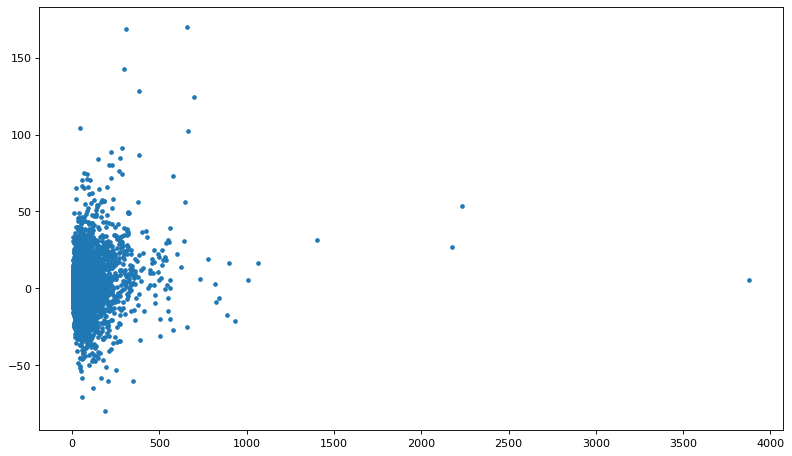

In [14]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [15]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(40)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,1,BKNG,3.128244,1.0,1.283688,0,Consumer Discretionary,Booking Holdings
1159,2001,1,FFIV,2.119789,1.0,1.097561,1,Information Technology,"F5, Inc."
2316,2001,1,AKAM,1.438936,1.0,1.041013,2,Information Technology,Akamai
3473,2001,1,WDC,1.409844,1.0,1.540424,3,Information Technology,Western Digital
4630,2001,1,ILMN,1.233873,1.0,0.565574,4,Health Care,Illumina
5787,2001,1,AMZN,1.107326,1.0,1.180115,5,Consumer Discretionary,Amazon
6943,2001,1,VRSN,1.053916,1.0,1.183142,6,Information Technology,Verisign
8098,2001,1,NTAP,0.982240,1.0,0.996306,7,Information Technology,NetApp
9250,2001,1,EQIX,0.974886,1.0,1.044944,8,Real Estate,Equinix
10399,2001,1,NVDA,0.940861,1.0,1.384102,9,Information Technology,Nvidia


In [16]:
ledger[ledger["position"]<20].sort_values("actual_returns",ascending=False).head(50)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
1560,2008,44,LVS,6.572759,1.0,2.703030,1,Consumer Discretionary,Las Vegas Sands
386,2008,29,UAL,3.094461,1.0,2.686901,0,Industrials,United Airlines Holdings
1545,2008,29,AAL,2.959162,1.0,2.426136,1,Industrials,American Airlines Group
6205,2009,11,AIG,3.828571,1.0,2.285714,5,Financials,American International Group
1564,2008,49,HIG,6.979733,1.0,2.244444,1,Financials,Hartford (The)
1282,2003,22,ILMN,0.474769,1.0,2.043902,1,Health Care,Illumina
79,2002,30,WMB,6.636513,1.0,2.025210,0,Energy,Williams Companies
421,2009,14,MGM,2.845833,1.0,1.909871,0,Consumer Discretionary,MGM Resorts
6957,2001,15,SBAC,2.252800,1.0,1.885121,6,Real Estate,SBA Communications
59,2002,10,SBAC,3.805660,1.0,1.866412,0,Real Estate,SBA Communications


In [17]:
ledger["actual_returns"].mean()

1.007350760982631

In [18]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5398405497070872

In [19]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [20]:
portfolio.head(20)

position,year,week,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2001,1,1.283688,1.097561,1.041013,1.540424,0.565574,1.180115,1.183142,0.996306,...,1.114626,1.105664,1.008353,0.994180,1.142300,1.113339,0.738498,1.063830,1.437500,1.164812
1,2001,2,1.746087,1.845304,1.144889,1.574903,1.122100,1.510753,1.203376,1.143333,...,1.354998,0.797394,1.027598,1.070166,1.008963,1.292683,1.348866,1.295686,1.031250,1.234533
2,2001,3,1.277778,1.041459,0.914985,1.013885,1.049280,1.111930,1.042278,1.265440,...,1.168239,1.192122,1.056297,0.939518,1.278521,0.950498,1.049885,1.060156,1.269453,1.052714
3,2001,4,1.244427,1.645714,1.235362,0.991117,1.065070,0.955182,1.001250,0.999472,...,1.205436,1.113599,1.106520,1.206560,0.988509,1.000000,1.095277,0.887450,0.828298,0.949254
4,2001,5,0.888036,0.890972,1.260191,1.103713,0.937143,1.064857,0.834123,0.940789,...,0.834741,0.900552,0.992821,0.995546,0.977986,0.940655,0.958159,0.973549,1.038189,0.955370
5,2001,6,0.801873,0.869703,0.943102,0.932568,0.797203,0.845227,1.012270,0.824826,...,0.876808,0.959394,1.098039,0.889376,1.028045,0.888803,0.841157,0.884358,0.794975,0.789654
6,2001,7,0.797394,0.864449,0.715114,0.949290,0.808282,0.875777,1.111570,0.881754,...,0.961538,0.991033,1.019077,0.790500,0.950739,1.101449,1.222222,1.019504,0.782040,0.977820
7,2001,8,0.808416,0.836437,0.953411,0.840936,0.951531,0.920952,0.890511,0.940000,...,1.007761,1.066194,1.140458,0.863014,1.328847,1.040824,0.869565,1.004577,0.984375,0.951038
8,2001,9,1.004212,0.934426,0.915937,1.084171,0.992032,1.203333,1.019090,1.000000,...,1.011064,1.064220,1.018365,0.927107,0.906043,0.812817,0.982995,1.061657,0.786032,0.793651
9,2001,10,0.927501,0.778233,0.960702,0.915236,0.793548,0.777303,0.960862,0.910828,...,0.792156,0.964313,0.932624,0.934933,0.883538,0.900985,0.821990,0.843646,0.908864,0.891936


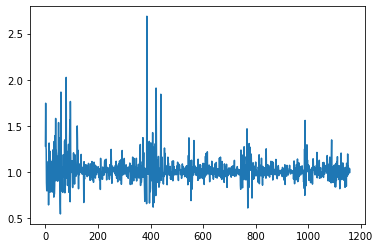

In [21]:
plt.plot(portfolio[0])

In [22]:
positions = 20

In [23]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [24]:
anas.naming

'week'

In [25]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,18,19,year,week,pv,daily_returns,adjclose,bench,date_string,date
5522,1.029775e+06,4826.614327,13.157223,8.873441,4.818121,558.768662,1176.577464,271.938252,2.595015,50.161424,...,2.003078,126.159979,2023,26,51881.496734,1.016214,13492.52,NaN,2023-W26,2023-06-30
5523,1.021481e+06,4673.199074,12.133102,9.037991,5.013023,563.254454,1203.929526,270.990915,2.651318,49.646982,...,1.996331,121.169407,2023,28,51460.589702,0.995383,13816.77,NaN,2023-W28,2023-07-14
5524,1.021481e+06,4673.199074,12.133102,9.037991,5.013023,563.254454,1203.929526,270.990915,2.651318,49.646982,...,1.996331,121.169407,2023,28,51460.589702,0.995383,13791.65,NaN,2023-W28,2023-07-14
5525,1.021481e+06,4673.199074,12.133102,9.037991,5.013023,563.254454,1203.929526,270.990915,2.651318,49.646982,...,1.996331,121.169407,2023,28,51460.589702,0.995383,13679.04,NaN,2023-W28,2023-07-14
5526,1.021481e+06,4673.199074,12.133102,9.037991,5.013023,563.254454,1203.929526,270.990915,2.651318,49.646982,...,1.996331,121.169407,2023,28,51460.589702,0.995383,13660.72,NaN,2023-W28,2023-07-14
5527,1.054493e+06,5105.902692,12.147854,9.945150,5.167828,575.267908,1241.770379,280.472497,2.813174,52.060256,...,1.933882,118.598336,2023,29,53137.114535,1.027014,13685.48,NaN,2023-W29,2023-07-21
5528,1.054493e+06,5105.902692,12.147854,9.945150,5.167828,575.267908,1241.770379,280.472497,2.813174,52.060256,...,1.933882,118.598336,2023,29,53137.114535,1.027014,13760.70,NaN,2023-W29,2023-07-21
5529,1.054493e+06,5105.902692,12.147854,9.945150,5.167828,575.267908,1241.770379,280.472497,2.813174,52.060256,...,1.933882,118.598336,2023,29,53137.114535,1.027014,13918.96,NaN,2023-W29,2023-07-21
5530,1.054493e+06,5105.902692,12.147854,9.945150,5.167828,575.267908,1241.770379,280.472497,2.813174,52.060256,...,1.933882,118.598336,2023,29,53137.114535,1.027014,14138.57,NaN,2023-W29,2023-07-21
5531,1.054493e+06,5105.902692,12.147854,9.945150,5.167828,575.267908,1241.770379,280.472497,2.813174,52.060256,...,1.933882,118.598336,2023,29,53137.114535,1.027014,14113.70,NaN,2023-W29,2023-07-21


In [26]:
cash_analysis = cumulative.copy()
cash_analysis["previous_day"] = cash_analysis["daily_returns"].shift(1)
cash_analysis["base"] = [min(row[1]["previous_day"],1) for row in cash_analysis.iterrows()]
cash_analysis["real_return"] = cash_analysis["base"] * cash_analysis["daily_returns"]
cash_analysis["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cash_analysis.iterrows()]
cash_analysis["running_cash"] = cash_analysis["cash"].cumsum()

In [27]:
cash_analysis["cash"].sum()

10402.08012154593

In [28]:
cash_analysis[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,1.109999,NaN,NaN,0.000000,0.000000
1,1.259743,1.000000,1.259743,25.974300,25.974300
2,1.259743,1.000000,1.259743,25.974300,51.948600
3,1.259743,1.000000,1.259743,25.974300,77.922899
4,1.259743,1.000000,1.259743,25.974300,103.897199
...,...,...,...,...,...
5527,1.027014,0.995383,1.022272,2.227233,10391.274678
5528,1.027014,1.000000,1.027014,2.701361,10393.976039
5529,1.027014,1.000000,1.027014,2.701361,10396.677400
5530,1.027014,1.000000,1.027014,2.701361,10399.378761


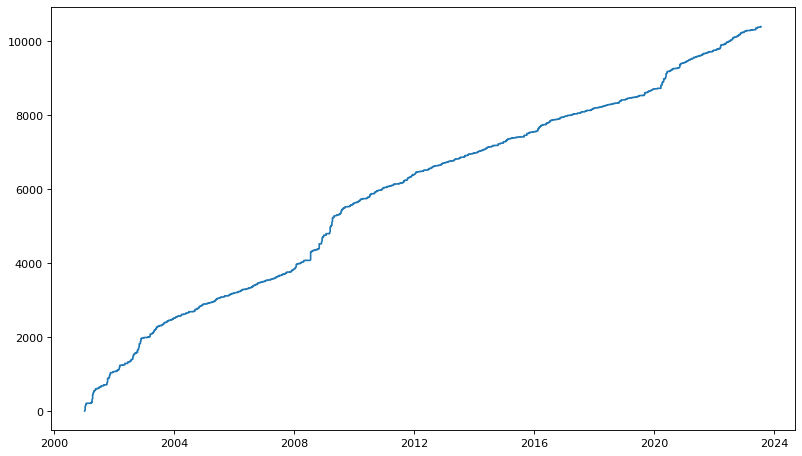

In [29]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cash_analysis["date"],cash_analysis["running_cash"])

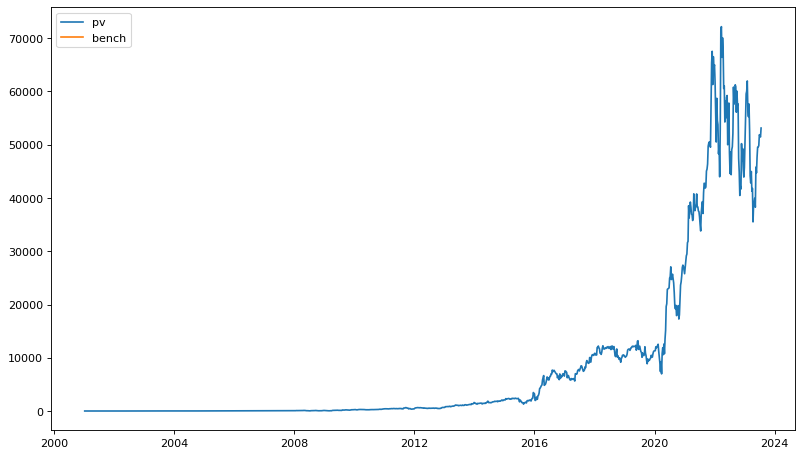

In [30]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [31]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,18,19,year,week,pv,daily_returns,adjclose,bench,date_string,date
0,1.283688,1.097561,1.041013,1.540424,0.565574,1.180115,1.183142,0.996306,1.044944,1.384102,...,1.437500,1.164812,2001,1,1.109999,1.109999,2291.86,NaN,2001-W1,2001-01-05
1,2.241431,2.025334,1.191844,2.426017,0.634630,1.782862,1.423765,1.139110,1.287167,1.675003,...,1.482422,1.437999,2001,2,1.410296,1.259743,2291.86,NaN,2001-W2,2001-01-12
2,2.241431,2.025334,1.191844,2.426017,0.634630,1.782862,1.423765,1.139110,1.287167,1.675003,...,1.482422,1.437999,2001,2,1.410296,1.259743,2616.69,NaN,2001-W2,2001-01-12
3,2.241431,2.025334,1.191844,2.426017,0.634630,1.782862,1.423765,1.139110,1.287167,1.675003,...,1.482422,1.437999,2001,2,1.410296,1.259743,2566.83,NaN,2001-W2,2001-01-12
4,2.241431,2.025334,1.191844,2.426017,0.634630,1.782862,1.423765,1.139110,1.287167,1.675003,...,1.482422,1.437999,2001,2,1.410296,1.259743,2407.65,NaN,2001-W2,2001-01-12
5,2.241431,2.025334,1.191844,2.426017,0.634630,1.782862,1.423765,1.139110,1.287167,1.675003,...,1.482422,1.437999,2001,2,1.410296,1.259743,1950.40,NaN,2001-W2,2001-01-12
6,2.864050,2.109303,1.090519,2.459702,0.665905,1.982418,1.483959,1.441475,1.267859,2.137304,...,1.881865,1.513801,2001,3,1.557817,1.099772,2395.92,NaN,2001-W3,2001-01-19
7,2.864050,2.109303,1.090519,2.459702,0.665905,1.982418,1.483959,1.441475,1.267859,2.137304,...,1.881865,1.513801,2001,3,1.557817,1.099772,2441.30,NaN,2001-W3,2001-01-19
8,2.864050,2.109303,1.090519,2.459702,0.665905,1.982418,1.483959,1.441475,1.267859,2.137304,...,1.881865,1.513801,2001,3,1.557817,1.099772,2524.18,NaN,2001-W3,2001-01-19
9,2.864050,2.109303,1.090519,2.459702,0.665905,1.982418,1.483959,1.441475,1.267859,2.137304,...,1.881865,1.513801,2001,3,1.557817,1.099772,2640.57,NaN,2001-W3,2001-01-19


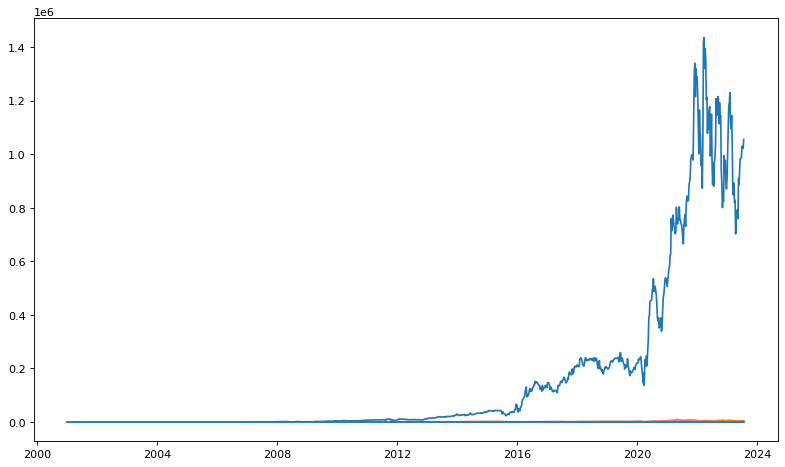

In [32]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
plt.show()


In [33]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Real Estate,2010.633816,28.135266,0.451259,1.0,1.012831,10.193237
Health Care,2010.615256,27.539816,0.300726,1.0,1.010253,9.105616
Industrials,2011.548444,25.773778,0.333781,1.0,1.009989,9.975556
Financials,2011.181867,25.119266,0.490943,1.0,1.007954,10.345926
Consumer Discretionary,2012.985118,26.014350,0.338645,1.0,1.007696,9.235185
Consumer Staples,2012.245753,26.144960,0.180561,1.0,1.006358,10.219706
Information Technology,2010.590599,25.267711,0.351500,1.0,1.006011,8.813579
Utilities,2011.427491,24.622951,0.272686,1.0,1.005938,9.962169
Materials,2012.822222,26.457265,0.295400,1.0,1.003929,9.484615


In [34]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  \
year week ticker Security                                      
2008 44   LVS    Las Vegas Sands                    6.572759   
     29   UAL    United Airlines Holdings           3.094461   
          AAL    American Airlines Group            2.959162   
2009 11   AIG    American International Group       3.828571   
2008 49   HIG    Hartford (The)                     6.979733   
2003 22   ILMN   Illumina                           0.474769   
2002 30   WMB    Williams Companies                 6.636513   
2009 14   MGM    MGM Resorts                        2.845833   
2001 15   SBAC   SBA Communications                 2.252800   
2002 10   SBAC   SBA Communications                 3.805660   
2001 2    BKNG   Booking Holdings                   2.725641   
2009 32   AIG    American International Group       1.470588   
2008 49   DXCM   Dexcom                             2.298462   
2020 12   PENN   Penn National Gaming               2.107963   
2002 46   SBAC   SBA Communications                 2.659615   
2009 15   HBAN   Huntington National Bank           0.660939   
2008 29   BAC    Bank of America                    0.850716   
2001 2    ILMN   Illumina                           2.846535   
2009 11   C      Citigroup                          5.782609   
2008 48   F      Ford Motor Company                 2.246154   
     29   ALK    Alaska Air Group                   0.853797   
2002 46   AMT    American Tower                     0.561667   
2008 29   HBAN   Huntington National Bank           0.999404   
2002 47   ALGN   Align Technology                   0.576139   
     43   AMT    American Tower                     0.904000   
2008 29   RF     Regions Financial Corporation      2.007627   
2020 23   AAL    American Airlines Group            0.246805   
2008 29   DAL    Delta Air Lines                    0.675431   
2001 4    EIX    Edison International               1.514620   
2002 44   AES    AES Corporation                    1.131707   

                                                weekly_delta_sign  \
year week ticker Security                                           
2008 44   LVS    Las Vegas Sands                              1.0   
     29   UAL    United Airlines Holdings                     1.0   
          AAL    American Airlines Group                      1.0   
2009 11   AIG    American International Group                 1.0   
2008 49   HIG    Hartford (The)                               1.0   
2003 22   ILMN   Illumina                                     1.0   
2002 30   WMB    Williams Companies                           1.0   
2009 14   MGM    MGM Resorts                                  1.0   
2001 15   SBAC   SBA Communications                           1.0   
2002 10   SBAC   SBA Communications                           1.0   
2001 2    BKNG   Booking Holdings                             1.0   
2009 32   AIG    American International Group                 1.0   
2008 49   DXCM   Dexcom                                       1.0   
2020 12   PENN   Penn National Gaming                         1.0   
2002 46   SBAC   SBA Communications                           1.0   
2009 15   HBAN   Huntington National Bank                     1.0   
2008 29   BAC    Bank of America                              1.0   
2001 2    ILMN   Illumina                                     1.0   
2009 11   C      Citigroup                                    1.0   
2008 48   F      Ford Motor Company                           1.0   
     29   ALK    Alaska Air Group                             1.0   
2002 46   AMT    American Tower                               1.0   
2008 29   HBAN   Huntington National Bank                     1.0   
2002 47   ALGN   Align Technology                             1.0   
     43   AMT    American Tower                               1.0   
2008 29   RF     Regions Financial Corporation                1.0   
2020 23   AAL    American Airlines Group                      1.0  

In [35]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2001,1,1.114626,1.200230,1.000000,1.000000,1.000000,0.789301,1.000000,1.167135,1.000000,1.044944,1.000000
1,4004001,2,1.510316,1.667051,1.000000,1.000000,1.000000,0.984241,1.000000,1.416246,1.000000,1.578652,0.797394
2,8012006001,6,1.589931,1.749708,1.000000,1.000000,1.000000,1.106903,1.000000,1.587758,0.939518,2.014360,0.729604
3,16032024008001,24,1.589931,1.877781,0.988509,1.000000,1.095277,1.209484,1.103280,1.581886,0.940693,2.014360,1.200719
4,32080080040010001,120,1.650648,1.766825,1.052620,1.000000,1.095277,1.330855,1.101754,1.495522,0.933940,2.014360,1.069808
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,0,0,4.465377,637.521779,17.854493,2.320771,83.768369,1992.338233,116.988867,56.248673,10.447635,5.690538,5.415593
1155,0,0,4.432613,654.374473,17.890773,2.320771,80.808476,1941.882592,116.988867,58.797381,10.438621,5.690538,5.415593
1156,0,0,4.569651,656.551860,18.196760,2.320771,80.781982,1997.419470,116.988867,60.404196,10.641333,5.690538,5.415593
1157,0,0,4.301424,652.425731,17.926752,2.320771,84.049766,2016.373432,116.988867,60.404196,10.882687,5.690538,5.415593
